In [1]:
# work in progress

In [2]:
# TODO

# NOTE could it be a confound if smaller pain reductions are not detected?
# or if big pain reductions are quite rare (3 per one trial over 4 min, as of now)
# -> should we only do "big" pain reductions?

In [3]:
import sys
from pathlib import Path
PROJECT_DIR = Path.cwd()
if PROJECT_DIR.stem == 'notebooks':
    PROJECT_DIR = PROJECT_DIR.parent
    sys.path.insert(0, '..')
    %load_ext autoreload
    %autoreload 2

In [4]:
import os
# os.environ["BOKEH_ALLOW_WS_ORIGIN"] = "06ff8e79l4jeiotimsl9bak9u3ck2v5s55k61cdin36plb0il69c"
os.environ["BOKEH_ALLOW_WS_ORIGIN"] = "12m0h5gjq9dg22vs1mbdqjhqj2tqndvlf05prafmri9ph52dvc4v"

import numpy as np
import matplotlib.pyplot as plt
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, Slider, Checkbox, Legend, LegendItem, Div
from bokeh.plotting import figure
from bokeh.layouts import row, column
from bokeh.application.handlers import FunctionHandler
from bokeh.application import Application
from src.experiments.stimuli_function import StimuliFunction, stimuli_extra


In [5]:
minimal_desired_duration = 200 # in seconds
periods = [67*2, 20] # [0] is the baseline and [1] the modulation; in seconds
frequencies = 1./np.array(periods)
amplitudes = [1, 1.5] # temp range is 2 * sum(amplitudes): max @ VAS 70, min @ VAS 0
sample_rate = 10
seed = None #823 # use None for random seed
baseline_temp = 39.2 # @ VAS 35

In [6]:
output_notebook()

def modify_doc(doc):
    """Modifies the document with the given stimuli function and plots."""
    def create_stimuli():
        """Creates and returns a stimuli function."""
        return StimuliFunction(
            minimal_desired_duration,
            frequencies,
            amplitudes,
            sample_rate=sample_rate,
            random_periods=False)

    def create_sources(stimuli):
        """Creates and returns sources for wave, baseline, and modulation."""
        x = np.arange(0, stimuli.duration, 1 / stimuli.sample_rate)
        return [ColumnDataSource(data=dict(x=x, y=attr)) for attr in [stimuli.wave, stimuli.baseline, stimuli.modulation]]

    def create_plot():
        """Creates and returns a plot with wave, baseline, and modulation lines."""
        plot = figure(height=400, width=800)
        colors = ["navy", "grey", "grey"]
        line_dashes = ["solid", 'dotted', 'dashed']
        lines = [plot.line('x', 'y', source=source, line_width=2 if idx else 3, line_alpha=0.6, color=color, line_dash=line_dash) 
                  for idx, (source, color, line_dash) in enumerate(zip(sources, colors, line_dashes))]
        lines[1].visible = lines[2].visible = False
        plot.xaxis.axis_label = 'Time (s)'
        plot.yaxis.axis_label = 'Temperature - Baseline (°C)'

        # Add legend
        legend_labels = ['stimuli', 'baseline', 'modulation']
        legend_items = [LegendItem(label=label, renderers=[line]) for label, line in zip(legend_labels, lines)]
        legend = Legend(items=legend_items, location="center")
        plot.add_layout(legend, 'below')
        plot.legend.orientation = "horizontal"
        return plot, lines

    # Set up data
    stimuli = create_stimuli()
    sources = create_sources(stimuli)
    plot, lines = create_plot()

    def create_sliders():
        """Creates and returns sliders for periods and amplitudes."""
        sliders = [
            Slider(start=start, end=end, value=value, step=step, title=title) 
            for start, end, value, step, title in [
                (40, 200, 134, 1, "Period Baseline"), 
                (10, 40, 20, 1, "Period Modulation"),
                (0, 3, 1, 0.25, "Amplitude Baseline"), 
                (0, 3, 1.5, 0.25, "Amplitude Modulation")
                ]]
        return sliders

    def create_checkboxes():
        """Creates and returns checkboxes for random periods, plot baseline, and plot modulation."""
        return [Checkbox(label=label, active=False) for label in [
            "Plot Baseline", "Plot Modulation", "Random periods"]]

    def callback(attr, old, new):
        """Updates the stimuli, sources, and lines based on the slider and checkbox values."""
        amplitudes = np.array([sliders[2].value, sliders[3].value])
        periods = [sliders[0].value, sliders[1].value]
        frequencies = 1./np.array(periods)
        stimuli = StimuliFunction(
            minimal_desired_duration,
            frequencies,
            amplitudes,
            sample_rate=sample_rate,
            random_periods=checkboxes[2].active)
        x = np.arange(0, stimuli.duration, 1 / stimuli.sample_rate)
        y = stimuli.wave
        sources[0].data = dict(x=x, y=y)
        lines[1].visible = checkboxes[0].active
        if lines[1].visible:
            sources[1].data = dict(x=x, y=stimuli.baseline)
        lines[2].visible = checkboxes[1].active
        if lines[2].visible:
            sources[2].data = dict(x=x, y=stimuli.modulation)

    # Set up widgets
    sliders = create_sliders()
    checkboxes = create_checkboxes()
    for slider in sliders:
        slider.on_change('value', callback)
    for checkbox in checkboxes:
        checkbox.on_change('active', callback)

    # Set up layouts and add to document
    periods_title = Div(text=f"<h2>Periods{'&nbsp;'*42}</h2>")
    amplitudes_title = Div(text="<h2>Amplitudes</h2>")
    titles = row(periods_title, amplitudes_title)
    baseline_slider_rows = row(sliders[0], sliders[2])
    modulation_slider_row = row(sliders[1], sliders[3]) 
    checkbox_row = row(*checkboxes)
    layout = column(titles, baseline_slider_rows, modulation_slider_row, checkbox_row, plot)
    doc.add_root(layout)

handler = FunctionHandler(modify_doc)
app = Application(handler)
show(app)


Loading BokehJS ...

In [7]:
stimuli = StimuliFunction(
    minimal_desired_duration,
    frequencies,
    amplitudes,
    sample_rate,
    random_periods=True,
    seed=seed
).add_baseline_temp(
    baseline_temp
).add_plateaus(
    plateau_duration=20, 
    n_plateaus=4, 
    add_at_start="random", 
    add_at_end=True)
print(f"Seed: {stimuli.seed}")
_ = stimuli_extra(stimuli.wave, stimuli.wave_dot, stimuli.sample_rate, s_RoC=0.2, display_stats=True)

Seed: 935


Cooling segments [s] based on 'Label_alt' with a rate of change threshold of 0.2 (°C/s):

count    9.00
mean     3.58
std      0.97
min      2.20
25%      3.20
50%      3.30
75%      4.10
max      5.30
dtype: object


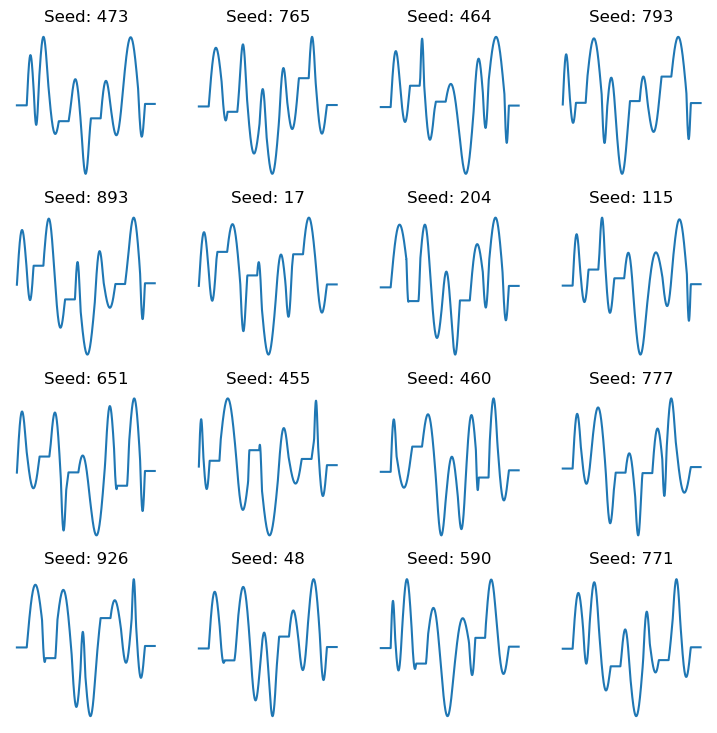

In [8]:
# Plot stimuli
rows, cols = 4, 4
fig, axes = plt.subplots(rows, cols, figsize=(9, 9), dpi=100)
random_seeds = np.random.randint(0, 1000, rows*cols)

for ax, random_seed in zip(axes.flat, random_seeds):
    stimuli = StimuliFunction(
        minimal_desired_duration,
        frequencies,
        amplitudes,
        sample_rate,
        random_periods=True,
        seed=random_seed
    ).add_plateaus(
        plateau_duration=20, 
        n_plateaus=4, 
        add_at_start="random", 
        add_at_end=True
    ).wave
    ax.plot(stimuli)
    ax.set_title(f"Seed: {random_seed}")
    ax.axis(False)